I've now fixed some more bugs (I hadn't implemented the mid connection). Let's test.

In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionXLPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)

beta_schedule = "scaled_linear" and beta_start=0.00085, beta_end=0.012
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
beta_schedule = "scaled_linear" and beta_start=0.00085, beta_end=0.012
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [5]:
from diffusers.models.controlnetxs import ControlNetXSModel

In [6]:
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

In [7]:
cnxs.base_model = sdxl_pipe.unet

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [8]:
from diffusers import EulerDiscreteScheduler

In [9]:
scheduler_cfg = {**sdxl_pipe.scheduler.config} # get unfrozen dict
scheduler_cfg['timestep_spacing'] = 'linspace'

In [10]:
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cfg)

beta_schedule = "scaled_linear" and beta_start=0.00085, beta_end=0.012
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [11]:
assert sdxl_pipe.scheduler.config.timestep_spacing=='linspace'

In [12]:
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [13]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Prepare the input to it

(Later, this will be done by the corresponding pipeline)

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers.utils import load_image

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, size=512, threshold=(50, 200)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

## Let's run the denoising loop with control

Let's fix the random seed so we get the same results as the paper. (The paper uses `pytorch_lightning.utilities.seed.seed_everything` which is doesn't exist anymore).

In [15]:
import random
import numpy as np
import torch

def seed_everything(seed):
    # paper u
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

RANDOM_SEED_IN_PAPER = 1999158951

Let's also use the same latents as was used with the Heidelberg CVL implementation

In [16]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0]

In [17]:
rand_from_cloud.shape

torch.Size([1, 4, 96, 96])

In [18]:
rand_from_cloud.mean(), rand_from_cloud.std()

(tensor(0.0021, device='mps:0'), tensor(14.6598, device='mps:0'))

**Note:** The seed from the cloud has 0 and ~15. I seem to have downlaoded the seed *after* the scaling, so let's unscale it manually.

For that, let's look up sigma_0 (when using `timestep_spacing='linspace'`, as I've set above).

In [19]:
cnxs_pipe.scheduler.sigmas

tensor([14.6146, 14.5263, 14.4386,  ...,  0.0413,  0.0292,  0.0000])

In [20]:
cnxs_pipe.scheduler.set_timesteps(50)

sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...


In [21]:
rand_from_cloud /= 14.6146

Reset the scheduler

In [22]:
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cfg)

beta_schedule = "scaled_linear" and beta_start=0.00085, beta_end=0.012
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


Some prep to better inspect the denoising process

In [23]:
def save_latents(i,t,lat,lats):
    if i==0 and len(lat)>0: lats = []
    lats.append((i,t,lat))

from PIL import Image, ImageOps, ImageDraw
from tqdm.notebook import tqdm
from functools import partial

def lat2img(lat, resize_to=None, output_type='pil'):
    with torch.no_grad():
        ims = cnxs_pipe.vae.decode(lat / cnxs_pipe.vae.config.scaling_factor, return_dict=False)[0]
        ims = cnxs_pipe.image_processor.postprocess(ims, output_type=output_type)
        if resize_to is not None:
            if output_type=='pil': ims = [im.resize(resize_to) for im in ims]
            else: print(f'Not resizing as output_type = {output_type} requested')
    return ims

def only_lat(o): return o[-1] if isinstance(o,tuple) else o
def lats2imgs(lats, resize_to=None, output_type='pil',pbar=True):
    if pbar: lats = tqdm(lats)
    ims = [lat2img(only_lat(lat), resize_to, output_type) for lat in lats]
    if output_type=='pt': ims = [im.cpu() for im in ims]
    return ims

real_idx = None
def plot_latents_to_pil_grid(lats, every=5, cols=7, im_size=(300, 300), pbar=True, border=2, return_ims=True, output_type='pil'):
    global real_idx
    
    real_idx = partial(lambda o,every,total: min(total-1,every*o), every=every, total=len(lats))
    
    titles = [f'Image {i}' for i, _, _ in lats if i % every == 0 or i == len(lats)-1]
    lats = [lat for i, _, lat in lats if i % every == 0 or i == len(lats)-1]
    if pbar: lats = tqdm(lats)
    ims = [lat2img(lat, resize_to=im_size, output_type=output_type)[0] for lat in lats]
    ims_bordered = [ImageOps.expand(im, border=2, fill='black') for im in ims]
    im_size = (im_size[0]+border, im_size[1]+border)

    rows = len(ims) // cols
    if rows * cols < len(ims): rows += 1

    grid_image = Image.new('RGB', (cols * im_size[0], rows * im_size[1]), color='grey')
    # draw diagonal white lines
    draw = ImageDraw.Draw(grid_image)
    for xy in range(0,2*max(cols * im_size[0], rows * im_size[1])+1,100):
        draw.line([(xy, 0), (0, xy)], fill="white", width=1)
    
    for i, img in enumerate(ims_bordered):
        x_offset = (i % cols) * im_size[0]
        y_offset = (i // cols) * im_size[1]
        grid_image.paste(img, (x_offset, y_offset))

    if return_ims: return grid_image, ims
    else: return grid_image

Okay, let's go

In [24]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

In [25]:
image = load_image('input_images/shoe.png')
edges = get_canny_edges(image)

In [28]:
# RuntimeError: Given ... expected input [2, 1, 512, 512] to have 3 channels, but got 1 channels instead
# -> hint has 1 channel, but should have 3
# let'cheat
edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))
three_edges.shape

torch.Size([3, 768, 768])

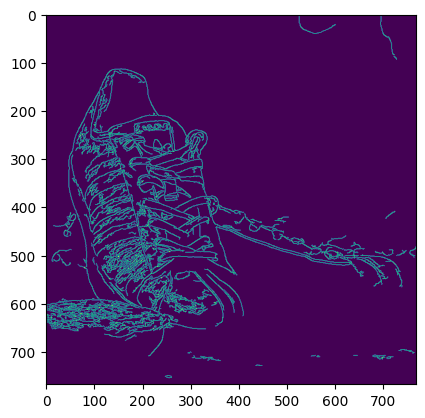

In [26]:
plt.imshow(edges)

In [30]:
# takes ~3min to run on cpu / ~1.5min on mps
seed_everything(RANDOM_SEED_IN_PAPER)
lats_cnxs_unfixed_noise = []
result_unfixed_noise = cnxs_pipe(
    prompt, negative_prompt=neg_prompt,image=three_edges,
    callback=partial(save_latents, lats=lats_cnxs_unfixed_noise),
)

sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604], device='mps:0') ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490], device='mps:0') ...
No latents passed in
initial_unscaled_latents:  tensor([ 1.1883,  1.1815,  0.0892, -0.8828, -0.6893], device='mps:0')
latents:  tensor([ 17.3665,  17.2672,   1.3038, -12.9013, -10.0744], device='mps:0')


  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
# takes ~3min to run on cpu / ~1.5min on mps
seed_everything(RANDOM_SEED_IN_PAPER)
lats_cnxs_fixed_noise = []
result = cnxs_pipe(
    prompt, negative_prompt=neg_prompt,image=three_edges,
    callback=partial(save_latents, lats=lats_cnxs_fixed_noise),
    latents=rand_from_cloud,
)

sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604], device='mps:0') ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490], device='mps:0') ...
Passed in latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
initial_unscaled_latents:  tensor([ 1.3333,  0.5155,  0.4647, -0.5344,  1.0102], device='mps:0')
latents:  tensor([19.4858,  7.5339,  6.7910, -7.8098, 14.7639], device='mps:0')


  0%|          | 0/50 [00:00<?, ?it/s]

This is CNXS without noise fixing (the seed is fixed though)

  0%|          | 0/50 [00:00<?, ?it/s]

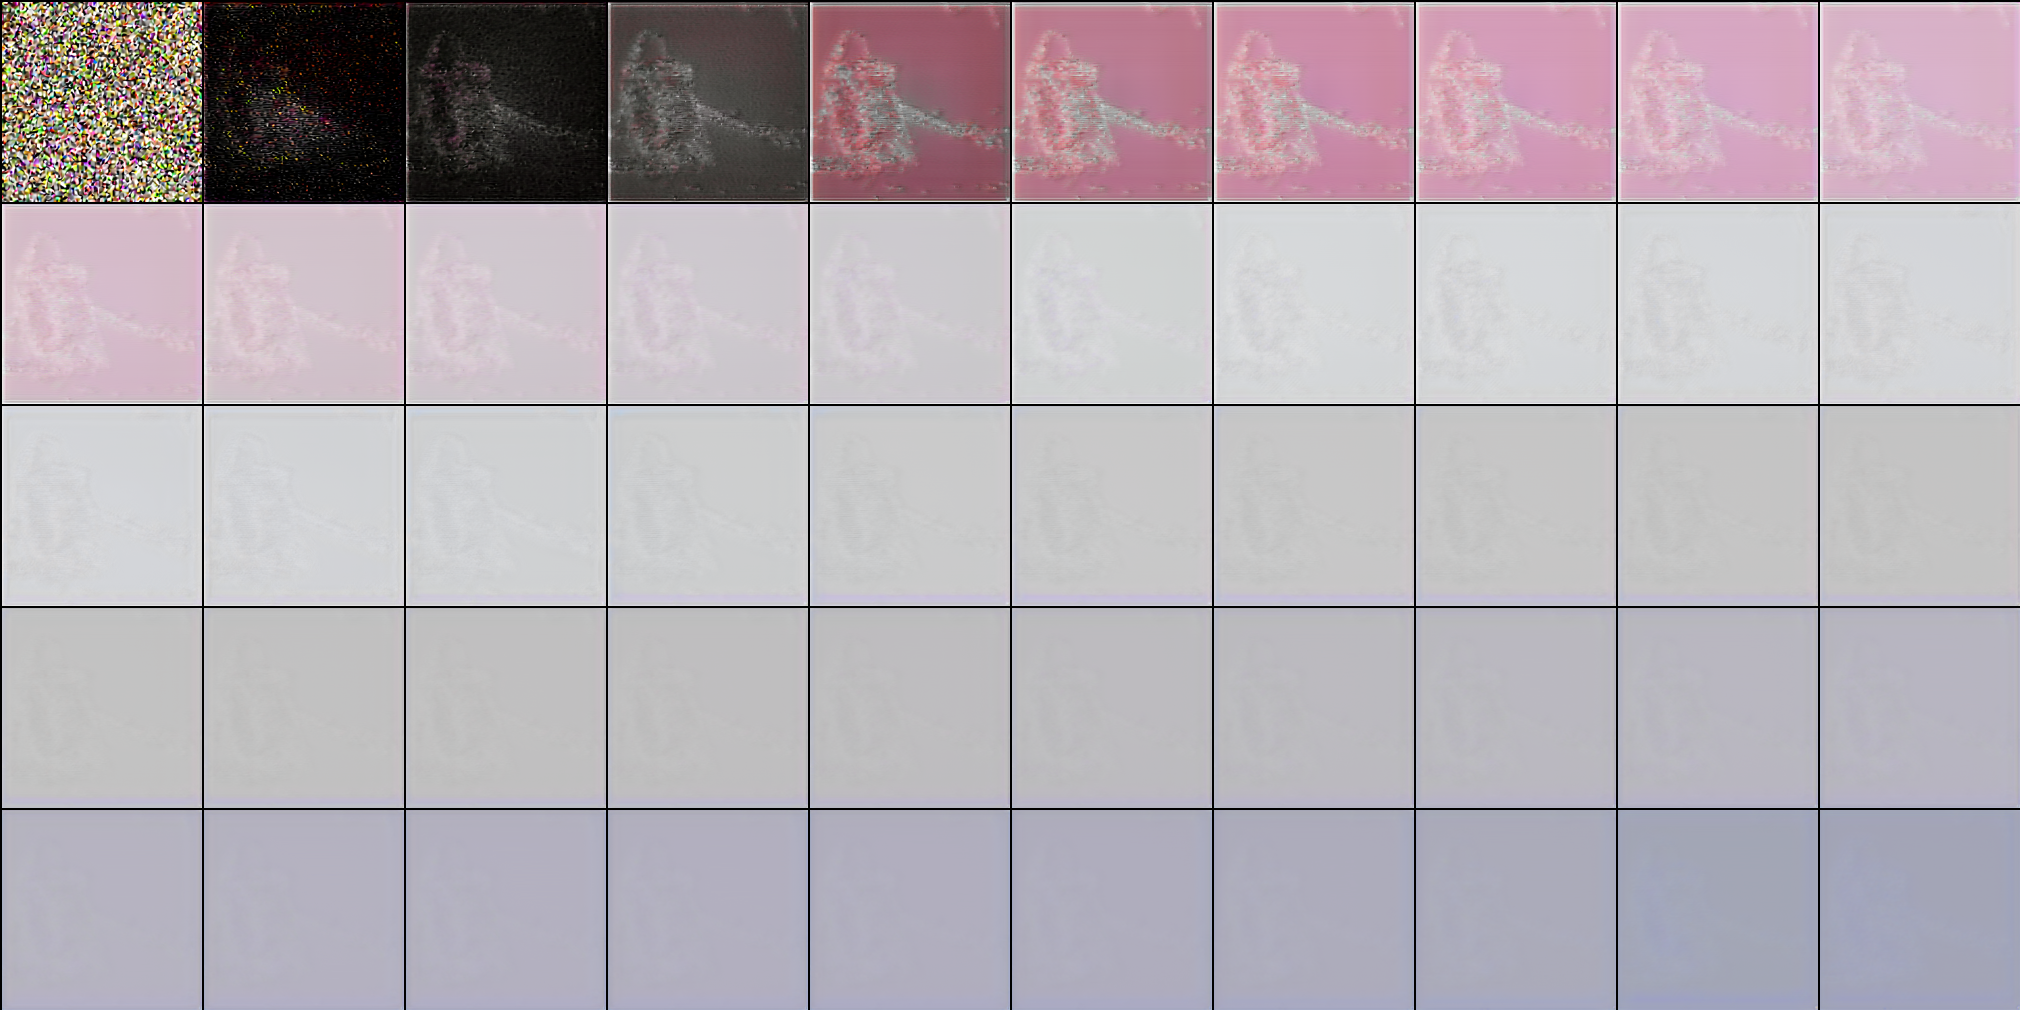

In [33]:
grid, ims_sdxl = plot_latents_to_pil_grid(lats_cnxs_unfixed_noise, every=1, cols=10, im_size=(200,200))
grid

This is SDXL with the same noise as on the cloud

  0%|          | 0/50 [00:00<?, ?it/s]

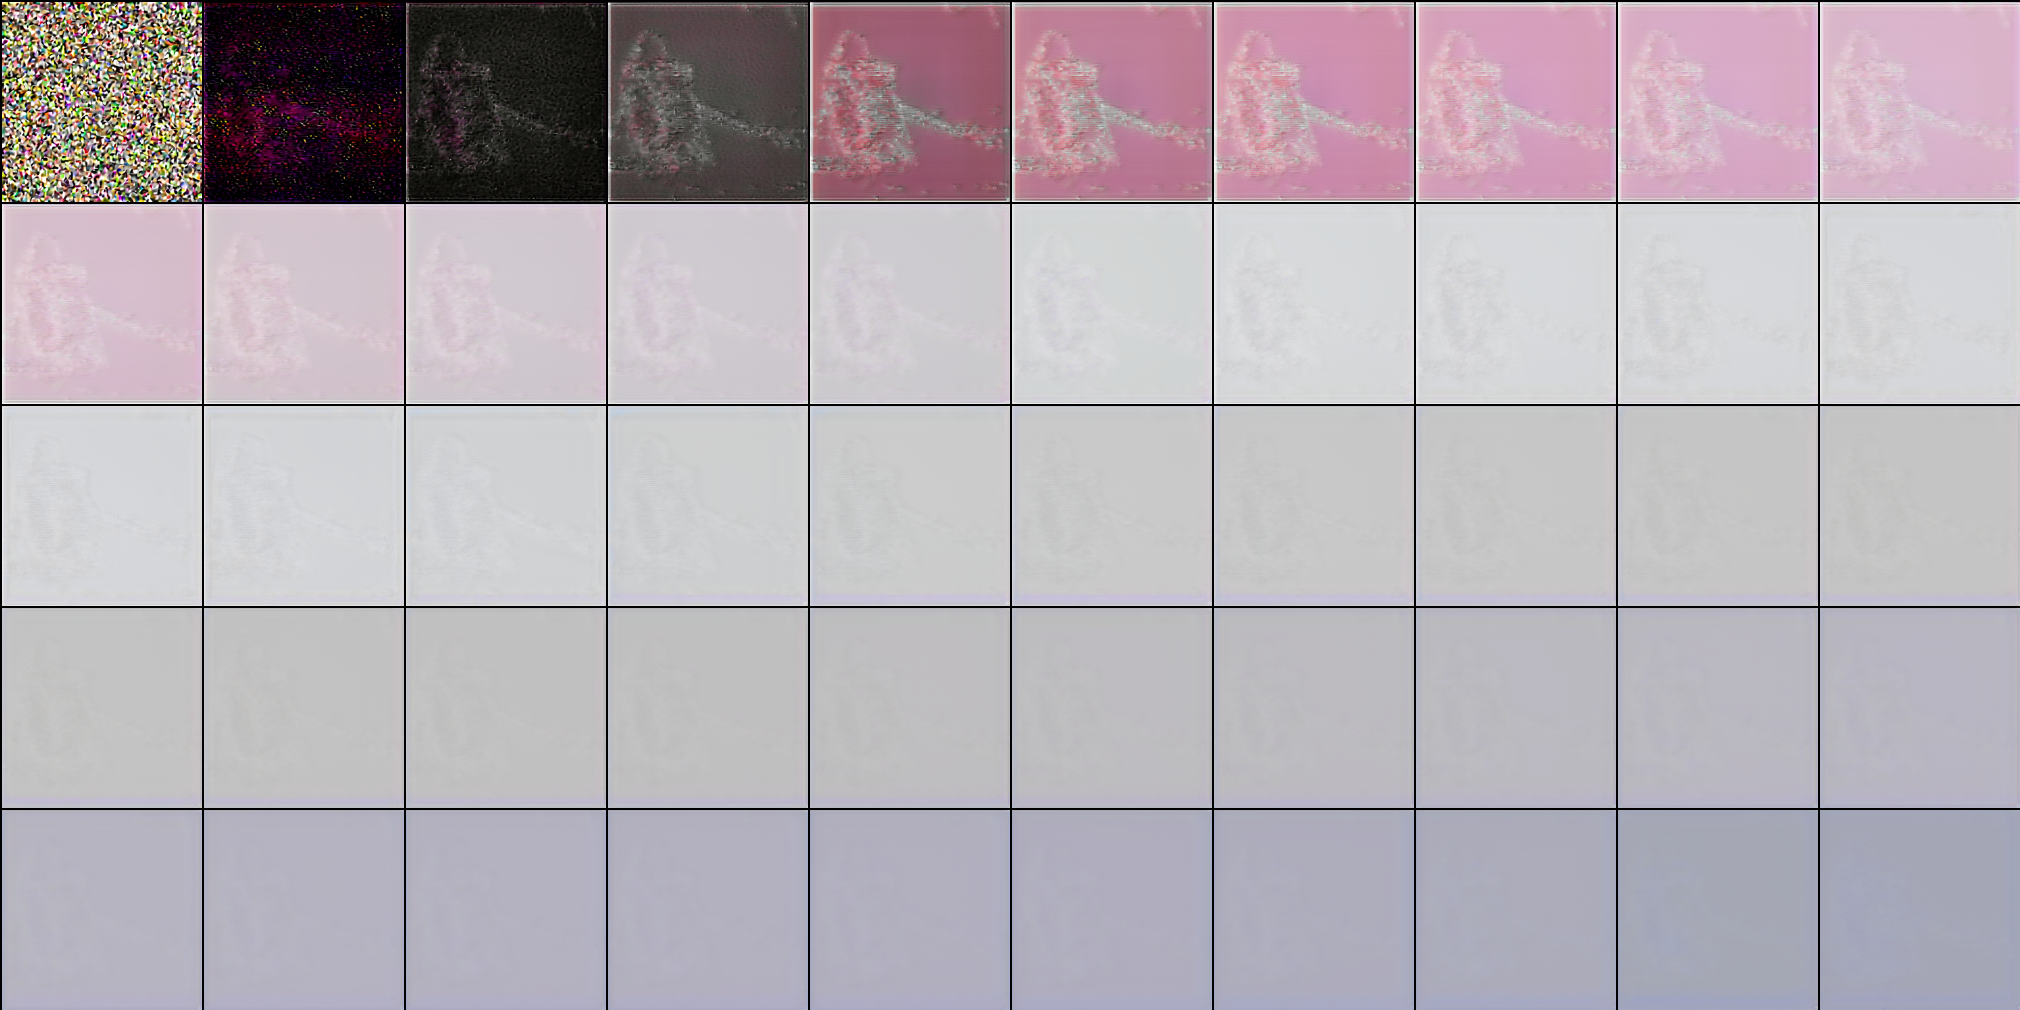

In [35]:
grid, ims_sdxl = plot_latents_to_pil_grid(lats_cnxs_fixed_noise, every=1, cols=10, im_size=(200,200))
grid